In [1]:
import pandas as pd
import numpy as np
import nltk
import pandas as pd
import re
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import transformers

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mitchellkijurina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mitchellkijurina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mitchellkijurina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mitchellkijurina/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Load data
df = pd.read_excel("Data.xlsx")
target = df['Orientation']

# Drop unnecessary columns
df = df.drop(['ID', 'DOI', 'PersonID', 'Orientation', 'Impact', 'Area of  research - person',
              'Area of research - publication', 'UT', 'SOURCE YEAR', 'Doc type',
              'Born', 'Position'], axis=1)

In [3]:
# Load the SciBERT tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Load the pre-trained SciBERT model
model = transformers.AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# Tokenize the text and encode it using SciBERT
def encode_text(text):
     # Encode the text using the tokenizer
    encoded = tokenizer(text, padding=True, truncation=True, return_tensors="pt") 
    with torch.no_grad():# Disable gradient calculation
        output = model(**encoded)[0] # Get the output of the model encoded 
    # Take the mean of the tensor put so a single vector, squeeze to remove the extra dimension and convert to a list
    return output.mean(dim=1).squeeze().tolist()

In [5]:
# Encode the 'TI' and 'AB' columns using SciBERT
df['TI_vector'] = df['TI'].apply(encode_text)
df['AB_vector'] = df['AB'].apply(encode_text)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [6]:
# Split the data into training, validation, and testing sets
X = np.concatenate((np.vstack(df['TI_vector'].values), np.vstack(df['AB_vector'].values)), axis=1)
y = target.values


In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)


In [8]:
# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=30, max_depth=4,
random_state=42, min_samples_leaf=3, n_jobs= 2)

# Train the Random Forest classifier on 'TI_vector'
rf_classifier.fit(X_train, y_train)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


RandomForestClassifier(max_depth=4, min_samples_leaf=3, n_estimators=30,
                       n_jobs=2, random_state=42)

In [9]:
y_val_pred = rf_classifier.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation accuracy for the RF model using Scibert" , accuracy_val)

Validation accuracy for the RF model using Scibert 0.5698324022346368


In [10]:
y_test_pred = rf_classifier.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test accuracy for the RF model using Scibert:", accuracy_test)


Test accuracy for the RF model using Scibert: 0.5642458100558659


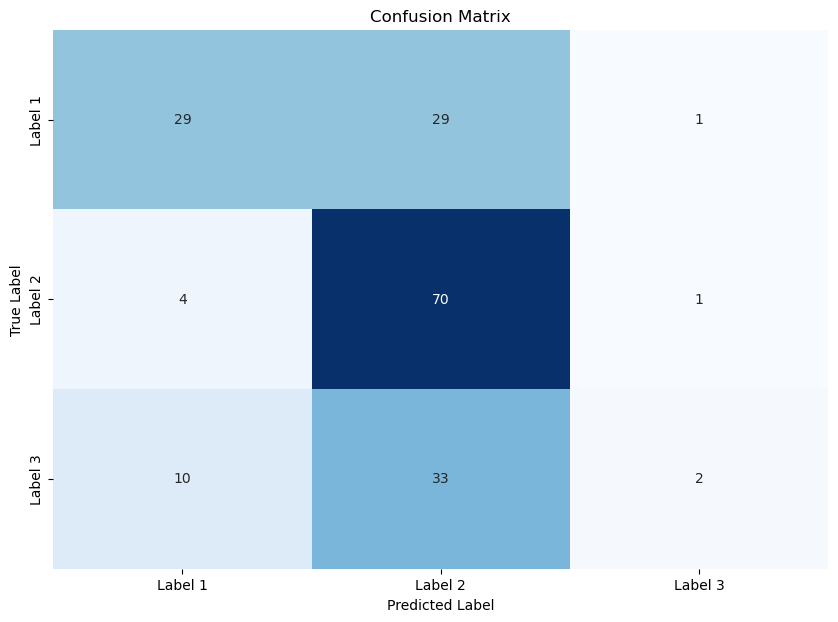

In [11]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

# Create confusion matrix plot using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Label 1', 'Label 2', 'Label 3'], yticklabels=['Label 1', 'Label 2', 'Label 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Calculate precision, recall and F1 score
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("Test set Accuracy:", accuracy_test)
print("Test set Precision:", precision)
print("Test set Recall:", recall)
print("Test set F1 Score:", f1)

Test set Accuracy: 0.5642458100558659
Test set Precision: 0.568240544984731
Test set Recall: 0.48976773383553046
Test set F1 Score: 0.4421962021523586


In [13]:
# check accuracy of train data
y_train_pred = rf_classifier.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Train accuracy for the RF model using Scibert:", accuracy_train)

Train accuracy for the RF model using Scibert: 0.7461077844311377
